<a href="https://colab.research.google.com/github/makucas/Deep-Residual-Learning-for-Image-Recognition/blob/main/Deep_Residual_Learning_for_Image_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ATIVIDADE 2

Implementar os experimentos (comparando n={3, 5}) descritos na sessão 4.2 do artigo "[Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf)" seguindo a API descrita em sala.

## Code

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import time
import numpy as np
from collections import defaultdict
import pdb

Apesar de não citar diretamente quantas épocas o modelo foi treinado, o paper especifica que o treinamento é finalizado em 64k iterações. Como o tamanho do minibatch utilizado é de 128, para calcular o número de épocas, nós dividimos o número total de iterações (64k) pelo número de minibatches por época. O número de minibatches por época é igual ao número total de exemplos de treinamento dividido pelo tamanho do minibatch. Como no caso do conjunto de dados CIFAR-10, existem 50k exemplos de treinamento.
Portanto, há 50k / 128 = aproximadamente 391 minibatches por época. Assim, o número de épocas é 64k / 391 = aproximadamente 164 épocas.

In [ ]:
# Get cpu, gpu or mps device for training.
DEVICE = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {DEVICE} device")

NUM_WORKERS = 0
NUM_EPOCHS = 164
LR_DECAY_FACTOR = 0.1
WEIGHT_DECAY = 0.0001
INITIAL_LR = 0.1
BATCH_SIZE = 128
GAMMA = 0.1
MOMENTUM = 0.9
STEP_SIZE = [82, 123]

Using cuda device



Através de nossa compreensão, a abordagem escolhida de data augmentation consiste em aplicar em aplicar uma série de transformações às imagens durante o treinamento, a fim de promover uma maior capacidade de generalização. No artigo, é mencionado que as transformações utilizadas incluem preenchimento, recorte aleatório e espelhamento horizontal. Além disso, as imagens são convertidas em tensores e normalizadas, garantindo assim uma representação consistente dos dados.

In [ ]:
def load_dataset(dataset):
    xs = []
    ys = []
    for x, y in dataset:
        xs += [x.to(DEVICE)]
        ys += [torch.tensor(y).view(-1,1).to(DEVICE)]
    xs = torch.cat(xs)
    ys = torch.cat(ys).view(-1,)
    return TensorDataset(xs, ys)

class Data:
    def __init__(self):
        root = 'data'
        means = [0.4914, 0.4822, 0.4465]
        stds = [0.2470, 0.2435, 0.2616]

        tensor_transform_train = transforms.Compose([
            transforms.Pad(4),
            transforms.RandomCrop(32),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(means, stds)
        ])

        tensor_transform_test = transforms.Compose([
            transforms.Resize((32,32)),
            transforms.ToTensor(),
            transforms.Normalize(means, stds)
        ])

        self.datasets = {}
        self.dataloaders = {}
        for is_train, transform in zip([True, False], [tensor_transform_train, tensor_transform_test]):
            ds = torchvision.datasets.CIFAR10(
                root=root,
                train=is_train,
                download=True,
                transform=transform,
            )
            self.datasets[is_train] = ds

            self.dataloaders[is_train] = DataLoader(
                self.datasets[is_train],
                BATCH_SIZE,
                shuffle=is_train,
                num_workers=NUM_WORKERS,
            )

    def get_loader(self, is_train: bool):
        return self.dataloaders[is_train]

In [ ]:
data = Data()

100%|██████████| 170498071/170498071 [00:02<00:00, 79809554.23it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [ ]:
data.datasets[True]

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               Pad(padding=4, fill=0, padding_mode=constant)
               RandomCrop(size=(32, 32), padding=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.2435, 0.2616])
           )

Na implementação do bloco residual do código estão presentes as seguintes características em conformidade com o artigo:

* Camadas convolucionais com tamanho de kernel 3x3.
* Utiliza normalização por batch após cada camada convolucional.
* Emprega ativação ReLU para introduzir não-linearidade.
* Possui conexões de atalho que são aplicadas aos pares de camadas 3x3.

`bias=False` pois de acordo com o artigo [16] referenciado no paper, "(...)a combinação da atualização do bias e a subsequente alteração na normalização resulta em nenhuma alteração na saída da camada e, consequentemente, nenhuma alteração na loss. À medida que o treinamento continua, bias crescerá indefinidamente enquanto a loss permanece fixa.(...)" e "(...) Observe que como normalizamos Wu+b, o bias b pode ser ignorado, pois seu efeito será cancelado pela subsequente subtração da média. (...)".

In [ ]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, residu, stride=1):
      super(Block, self).__init__()
      self.residu = residu

      self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
      self.bn1 = nn.BatchNorm2d(out_channels)
      self.relu = nn.ReLU(inplace=True)
      self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
      self.bn2 = nn.BatchNorm2d(out_channels)

      self.shortcut = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
        nn.BatchNorm2d(out_channels)
      ) if stride != 1 or in_channels != out_channels else nn.Sequential()

      # Inicializando peso He
      nn.init.kaiming_normal_(self.conv1.weight, nonlinearity='relu')
      nn.init.kaiming_normal_(self.conv2.weight, nonlinearity='relu')
      if stride != 1 or in_channels != out_channels:
          nn.init.kaiming_normal_(self.shortcut[0].weight, nonlinearity='relu')

    def forward(self, x):
      residual = x
      x = self.bn1(self.conv1(x))
      x = self.relu(x)
      x = self.bn2(self.conv2(x))
      if self.residu == True:
        x += self.shortcut(residual)
      x = self.relu(x)
      return x

A plain residual network que desenvolvemos segue a estrutura geral da arquitetura residuais descrita no artigo. Ela inclui a camada de convolução inicial, seguida pelos blocos residuais, média global, camada totalmente conectada e a função de ativação softmax.

In [ ]:
class PlainResidualNet(nn.Module):
    def __init__(self, n, residu):
      super(PlainResidualNet, self).__init__()
      self.in_channels = 16

      self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
      self.bn1 = nn.BatchNorm2d(16)
      self.relu = nn.ReLU(inplace=True)

      self.layer1 = self.make_layer(16, n, residu)
      self.layer2 = self.make_layer(32, n, residu, stride=2)
      self.layer3 = self.make_layer(64, n, residu, stride=2)

      self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
      self.fc = nn.Linear(64, 10)

      self._initialize_weights()

    def _initialize_weights(self):
      for m in self.modules():
          if isinstance(m, nn.Conv2d):
              n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
              m.weight.data.normal_(0, np.sqrt(2. / n))
          elif isinstance(m, nn.BatchNorm2d):
              m.weight.data.fill_(1)
              m.bias.data.zero_()

    def make_layer(self, out_channels, blocks, residu, stride=1):
      layers = []
      layers.append(Block(self.in_channels, out_channels, residu, stride=stride))
      self.in_channels = out_channels
      for i in range(1, blocks):
        layers.append(Block(out_channels, out_channels, residu))

      return nn.Sequential(*layers)

    def forward(self, x):
      x = self.bn1(self.conv1(x))
      x = self.relu(x)
      x = self.layer1(x)
      x = self.layer2(x)
      x = self.layer3(x)
      x = self.avg_pool(x)
      x = x.view(x.size(0), -1)
      x = self.fc(x)
      return x


 O paper utiliza um SGD com momentum de 0.9 e weight decay de 0.0001. A taxa de aprendizado inicial é 0.1, que é dividida por 10 em 32k e 48k iterações. No nosso código, usamos torch.optim.SGD com os mesmos parâmetros do paper. A taxa de aprendizado é modificada usando o torch.optim.lr_scheduler.MultiStepLR com as etapas definidas no início do notebook em STEP_SIZE (STEP_SIZE = [82, 123]), para cumprir a divisão em 32.000 e 48.000 iterações, que no nosso código as iterações são convertidas para épocas.

In [ ]:
class Learner:
    def __init__(self, n, residu=True):
        self.model = PlainResidualNet(n, residu)
        self.model.to(DEVICE)
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
        self.scheduler = torch.optim.lr_scheduler.MultiStepLR(self.optimizer, milestones=STEP_SIZE, gamma=GAMMA)

    def predict(self, x):
        return self.model(x)

    def update(self, loss):
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_learning_rate(self):
        self.scheduler.step()

Apesar do artigo não citar diretamente a função de perda a ser usada, entendemos que a função de perda CrossEntropyLoss seria a melhor opção, pois como a função CrossEntropyLoss combina a etapa de softmax, que converte as saídas do modelo em probabilidades de classe, com a etapa de entropia cruzada, que calcula a diferença entre as probabilidades previstas e os rótulos verdadeiros, essa função é eficaz para treinar modelos de classificação multiclasse, uma vez que busca minimizar a divergência entre as distribuições de probabilidade previstas e as distribuições corretas. Isso se aplica nesse caso de uso do dataset CIFAR-10 e por isso foi a função escolhida.

Como suporte a nossa afirmação temos um link de referência que demonstra matematicamente como a CrossEntropyLoss busca minimizar a divergência entre as distribuições de probabilidade previstas e as distribuições corretas. O link em questão é: https://github.com/zhangjh915/Softmax-Classifier-on-cifar10. Ele fornece uma análise detalhada que respalda a eficácia da CrossEntropyLoss como uma função de perda adequada para o treinamento de modelos de classificação multiclasse, como é o caso do CIFAR-10.

In [ ]:
class Evaluator:
    def __init__(self):
        self.loss_fn = nn.CrossEntropyLoss()

    def get_loss(self, y, y_hat):
        return self.loss_fn(y_hat, y)

In [ ]:
class Trainer:
    def __init__(self, data: Data, learner: Learner, evaluator: Evaluator):
        self.data = data
        self.learner = learner
        self.evaluator = evaluator
        self.log = defaultdict(list)

    def one_epoch(self, training: bool):
        self.learner.model.train(training)
        dataloader = self.data.get_loader(training)
        test_loss, correct = 0, 0
        num_batches = len(dataloader)
        size = len(dataloader.dataset)
        epoch_train_loss = 0
        epoch_correct_train = 0

        for batch_idx, (X, y) in enumerate(dataloader):
            X, y = X.to(DEVICE), y.to(DEVICE)
            y_hat = self.learner.predict(X)
            loss = self.evaluator.get_loss(y, y_hat)
            if training:
                _, predicted_train = torch.max(y_hat, 1)
                epoch_correct_train += (predicted_train == y).sum().item()
                epoch_train_loss += loss.item()
                self.learner.update(loss)

                if batch_idx % 50 == 0:
                    current = (batch_idx + 1) * len(X)
                    print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            else:
                test_loss += loss.item()
                _, predicted = torch.max(y_hat, 1)
                correct += (predicted == y).sum().item()

        if training:
          error_rate_train = 1 - (epoch_correct_train / size)
          self.log['train_error_rate'] += [error_rate_train]
          self.log['train_loss'] += [epoch_train_loss / num_batches]
        else:
          test_loss /= num_batches
          error_rate = 1 - (correct / size)
          self.log['error_rate'] += [error_rate]
          print(f"Test Error: \n Error rate: {(100 * error_rate):>0.1f}%, Avg loss: {test_loss:>8f} \n")
          self.learner.update_learning_rate()


    def run(self, n_epochs: int):
        for t in range(n_epochs):
            print(f"Epoch {t+1}\n-------------------------------")
            self.one_epoch(training=True)
            with torch.no_grad():
                self.one_epoch(training=False)

        print("Done!")

## Running

In [ ]:
evaluator = Evaluator()

Para permitir um plot com todos os modelos, vamos definir os learners e trainers necessários para que possamos utilizar os logs de cada um posteriormente

In [ ]:
# Criando learners
learner3_resnet = Learner(3, residu=True)
learner5_resnet = Learner(5, residu=True)
learner3_plain = Learner(3, residu=False)
learner5_plain = Learner(5, residu=False)

# Criando trainers
trainer3_resnet = Trainer(data, learner3_resnet, evaluator)
trainer5_resnet = Trainer(data, learner5_resnet, evaluator)
trainer3_plain = Trainer(data, learner3_plain, evaluator)
trainer5_plain = Trainer(data, learner5_plain, evaluator)

In [ ]:
# Executando
print('\n Starting 20 layers-network Resnet training \n')
trainer3_resnet.run(NUM_EPOCHS)
print('\n Starting 32 layers-network Resnet training \n')
trainer5_resnet.run(NUM_EPOCHS)
print('\n Starting 20 layers-network Plain network training \n')
trainer3_plain.run(NUM_EPOCHS)
print('\n Starting 32 layers-network Plain network training \n')
trainer5_plain.run(NUM_EPOCHS)


 Starting 20 layers-network Resnet training 

Epoch 1
-------------------------------
loss: 2.480599  [  128/50000]
loss: 1.761876  [ 6528/50000]
loss: 1.700451  [12928/50000]
loss: 1.420143  [19328/50000]
loss: 1.686626  [25728/50000]
loss: 1.546418  [32128/50000]
loss: 1.463456  [38528/50000]
loss: 1.266257  [44928/50000]
Test Error: 
 Error rate: 45.1%, Avg loss: 1.271077 

Epoch 2
-------------------------------
loss: 1.339938  [  128/50000]
loss: 1.191613  [ 6528/50000]
loss: 1.124861  [12928/50000]
loss: 1.218222  [19328/50000]
loss: 1.085086  [25728/50000]
loss: 1.034012  [32128/50000]
loss: 0.985035  [38528/50000]
loss: 0.763077  [44928/50000]
Test Error: 
 Error rate: 36.6%, Avg loss: 1.056398 

Epoch 3
-------------------------------
loss: 0.772567  [  128/50000]
loss: 0.857776  [ 6528/50000]
loss: 1.014701  [12928/50000]
loss: 0.908641  [19328/50000]
loss: 0.930182  [25728/50000]
loss: 0.890224  [32128/50000]
loss: 0.766552  [38528/50000]
loss: 0.858535  [44928/50000]
Test 

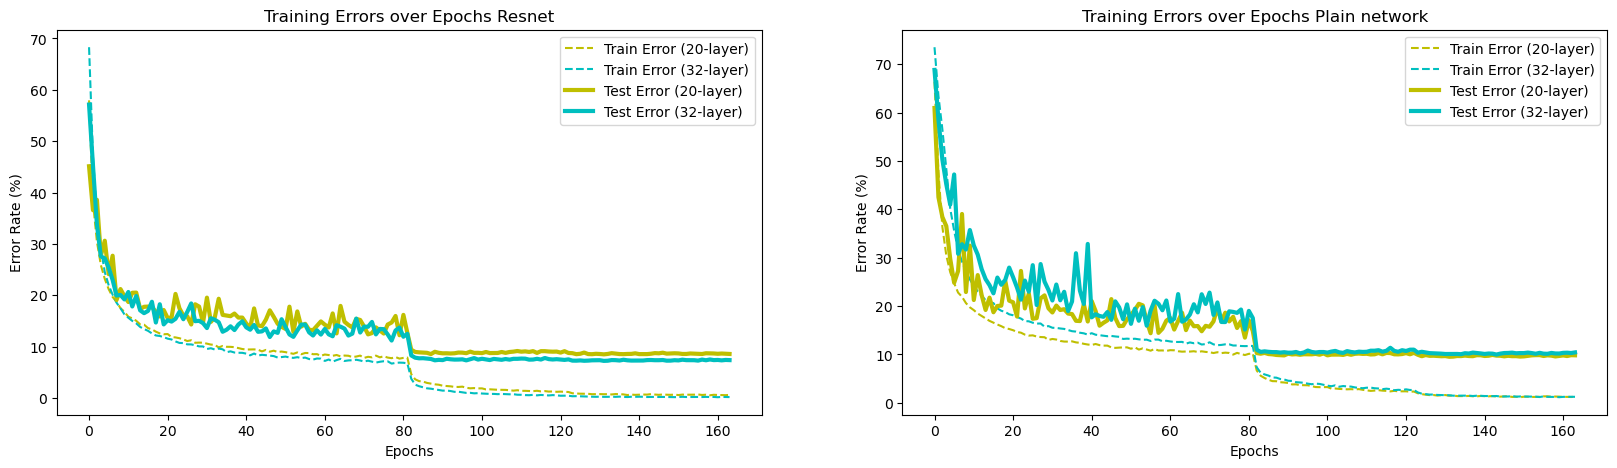

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

#Primeiro plot
# Erro do treino
ax1.plot([rate * 100 for rate in trainer3_resnet.log['train_error_rate']], 'y--', label='Train Error (20-layer)')
ax1.plot([rate * 100 for rate in trainer5_resnet.log['train_error_rate']], 'c--', label='Train Error (32-layer)')

# Erro teste
ax1.plot([rate * 100 for rate in trainer3_resnet.log['error_rate']], 'y-', linewidth=3, label='Test Error (20-layer)')
ax1.plot([rate * 100 for rate in trainer5_resnet.log['error_rate']], 'c-', linewidth=3, label='Test Error (32-layer)')

ax1.set_title('Training Errors over Epochs Resnet')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Error Rate (%)')
ax1.legend()

# Segundo plot
# Erro do treino
ax2.plot([rate * 100 for rate in trainer3_plain.log['train_error_rate']], 'y--', label='Train Error (20-layer)')
ax2.plot([rate * 100 for rate in trainer5_plain.log['train_error_rate']], 'c--', label='Train Error (32-layer)')

# Erro teste
ax2.plot([rate * 100 for rate in trainer3_plain.log['error_rate']], 'y-', linewidth=3, label='Test Error (20-layer)')
ax2.plot([rate * 100 for rate in trainer5_plain.log['error_rate']], 'c-', linewidth=3, label='Test Error (32-layer)')

ax2.set_title('Training Errors over Epochs Plain network')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Error Rate (%)')
ax2.legend()
plt.show()


* **Resnet:** O gráfico a esquerda mostra o comportamento da rede residual com 20 e 32 camadas, e suas respectivas taxas de erro. Assim como visto nos resultados do paper, ao aumentar o numero de camadas utilizando da **Resnet** a taxa de erro é reduzida, o que segundo os autores é excelente, uma vez que redes mais profundas são de importância crucial para obtenção de modelos mais eficientes.
* **Plain Network:** O gráfico a direita mostra o comportamento da rede plana com 20 e 32 camadas, e suas respectivas taxas de erro. Assim como visto nos resultados do paper, em uma rede plana aumentar o número de camadas expoẽ o problema da degradação, levando o modelo a uma maior imprecisão, o que foi uma das motivações pra a criação da solução proposta pelos autores.
* **É importante ressaltar que o experimento foi realizado de uma única vez, utilizando parâmetros iguais para todas as redes.**

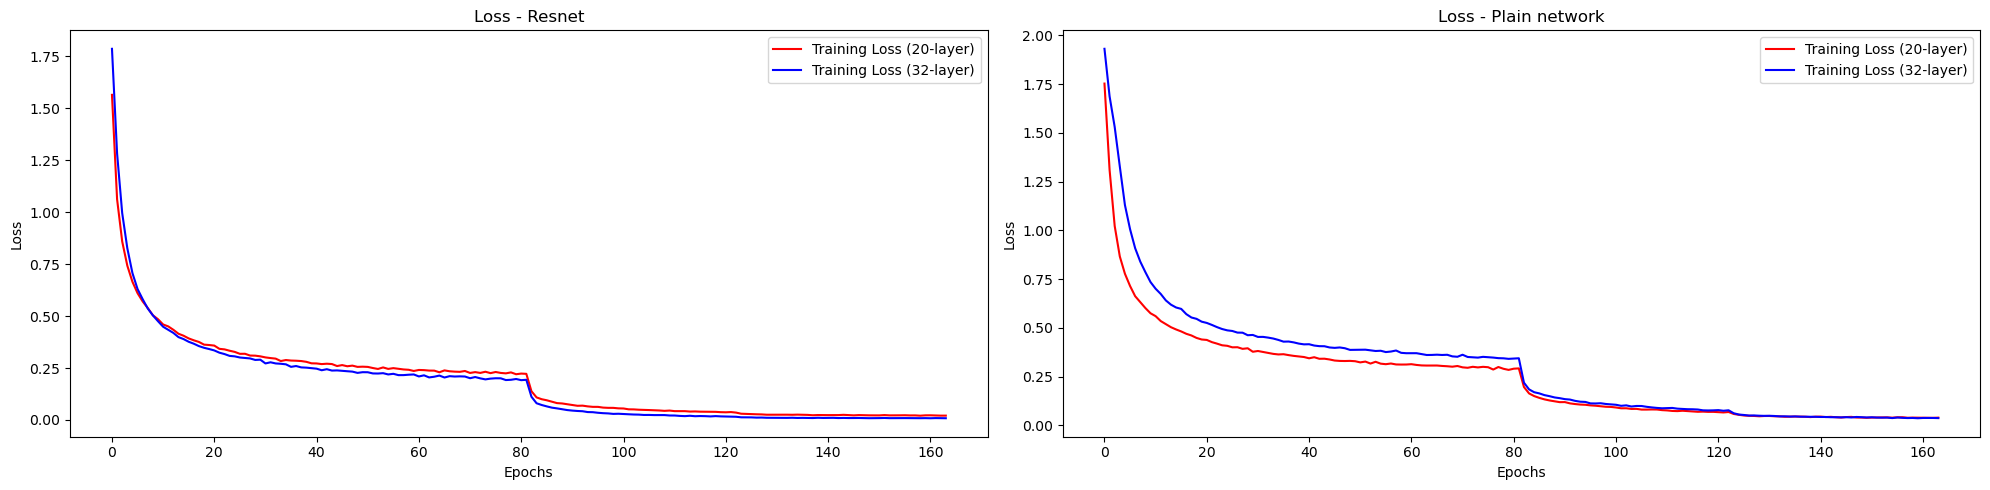

In [ ]:
# Gráfico da loss Resnet
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

# Gráfico da loss Resnet
ax1.plot(trainer3_resnet.log['train_loss'], 'r-', label='Training Loss (20-layer)')
ax1.plot(trainer5_resnet.log['train_loss'], 'b-', label='Training Loss (32-layer)')
ax1.set_title('Loss - Resnet')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Gráfico da loss Plain network
ax2.plot(trainer3_plain.log['train_loss'], 'r-', label='Training Loss (20-layer)')
ax2.plot(trainer5_plain.log['train_loss'], 'b-', label='Training Loss (32-layer)')
ax2.set_title('Loss - Plain network')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()


* **Gráficos da Loss:** Acima é possível observar o gráfico da loss tanto da **Resnet** quanto da **Plain Network**, corroborando com as explicações prévias deste experimento. Se torna evidente que a curva de ambas apresentam comportamentos inversos, ou seja, ao aumentar o número de camadas na **Resnet**, a loss fica menor, e ao aumentar o número de camadas na **Plain Network**, a loss fica maior.

* **Considerações finais:** Todos os híper parâmetros descritos no paper foram seguidos para realização deste experimento, salvo o trecho em que é mencionado que 10% dos dados de treino serão utilizados para validação, o que os autores descrevem como "*45/5k train/val split*". A priore esse ajuste seria feito, mas imprevistos ao longo do desenvolvimento dificultaram a execução do mesmo. De qualquer modo, como o comportamento principal observado no paper pode ser observado neste experimento, acreditamos que os impactos da falta do split não sejam tão grandes.